# SliCERR 

## Example notebook to run and visualize CERR segmentation in Slicer

### Setup and module load for Octave oct2py interface

In [ ]:
cerrPath = r'/Users/elocastro/Dev/CERR'

octave.eval("cerrPath = '" + cerrPath + "';")
octave.eval('addpath(cerrPath)')
octave.eval('addToPath2(cerrPath)')

In [ ]:
#user set local paths
#rename segdir to sessionpath

planCFileName = r'/Users/elocastro/Dev/sliCERR/data/0617-580557_09-09-2000-11778.mat';

sessionPath = r'/Users/elocastro/Dev/slicerr'
condaEnvName = r'/Users/elocastro/Dev/slicerr/condapack_mac_CT_Heart_DeepLab'
algorithm = r'CT_Pericardium_DeepLab' #read JSON file to get structure names readDLConfigFile
wrapperFunction = r'/Users/elocastro/Dev/slicerr/condapack_mac_CT_Heart_DeepLab/CT_Heart_DeepLab/model_wrapper/CT_Pericardium_DeepLab/runSegPericardium.py'

octave.eval("segdir = '" + segdir + "'; condaEnvName = '" + condaEnvName + "'; algorithm = '" + algorithm + "'; wrapperFunction = '" + wrapperFunction + "';")

In [ ]:
import os
import numpy as np

In [ ]:
import JupyterNotebooksLib as slicernb

In [ ]:
octave_cli_path = '/usr/local/bin/octave-cli'
os.environ['OCTAVE_EXECUTABLE'] = octave_cli_path

In [ ]:
from oct2py import octave
from oct2py import Struct

In [ ]:
%load_ext oct2py.ipython

In [ ]:
#import octave add-on packages
octave.eval('pkg load image')
octave.eval('pkg load io')
octave.eval('pkg load statistics')

In [ ]:
octave.warning('off','all');

In [ ]:
javaPath = r'/Library/Java/JavaVirtualMachines/jdk-16.0.2.jdk/Contents/Home/lib/server'
octave.setenv('JAVA_HOME',javaPath)

In [ ]:
#verify version of CERR

## Load planC

In [ ]:
octave.eval("planCFileName = '" + planCFileName + "';")

In [ ]:
octave.eval('planC = loadPlanC(planCFileName);')

In [ ]:
octave.eval('indexS = planC{end};')

In [ ]:
octave.eval('scanCount = numel(planC{indexS.scan});')
octave.eval('structCount = numel(planC{indexS.structures});')
octave.eval('doseCount = numel(planC{indexS.dose});')

countList = octave.pull(['scanCount','structCount','doseCount'])

#scanCount = octave.pull('scanCount')
#structCount = octave.pull('structCount')
#doseCount = octave.pull('doseCount')

In [ ]:
scanCount   = countList[0]
structCount = countList[1]
doseCount   = countList[2]

In [ ]:
if structCount != 0:
    importStruct = True
else:
    importStruct = False

if doseCount != 0:
    importDose = True
else:
    importDose = False

In [ ]:
scanList = []
structList = []
doseList = []

In [ ]:
if scanCount != 0:
    for i in range(int(scanCount)):
        print('Importing scan' + str(i+1))
        octave.push('i',i+1)
        octave.eval('scanType = planC{indexS.scan}(i).scanType;')
        scanType = octave.pull('scanType')
        octave.eval('structC = {};')
        octave.eval('doseNumV = [];')
        if importStruct:
            print('Import struct option found')
            structNodeName = scanType + '_struct'
            structureNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode", structNodeName)            
            for j in range(int(structCount)):
                octave.push('j',j+1)
                octave.eval('if planC{indexS.structures}(j).associatedScan == i; structC{end+1} = planC{indexS.structures}(j).structureName; end')
            octave.eval('assocStructCount = numel(structC);')
        if importDose:
            for k in range(int(doseCount)):
                octave.push('k',k+1)
                #octave.eval('if planC{indexS.dose}(k).associatedScan == i; doseNumV(end+1) = k; end')
                octave.eval('doseNumV = 1:k')
            octave.eval('disp(doseNumV);')
        octave.eval('[affineMat,scan3M_RAS,voxel_size,mask3MC, dose3MC] = getPlanCAffineMat(planC, i, 1, structC, doseNumV);')
        octave.eval("qOffset = affineMat(1:3,end)';")
        octave.eval('scaleMat = eye(3); scaleMat(1,1) = 1/voxel_size(1); scaleMat(2,2) = 1/voxel_size(2); scaleMat(3,3) = 1/voxel_size(3);ijkMat = scaleMat * affineMat(1:3,1:3);')
        affineMat, ijkMat, qOffset, scan3M_RAS, voxel_size = octave.pull(['affineMat','ijkMat','qOffset','scan3M_RAS','voxel_size'])
        if scanType == '':
            scanType = 'planC_scan_' + str(i+1)
        slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", scanType)
        scanList.append(slicer.util.getNode(scanType))
        #volumeNode = slicer.util.getNode(scanType)
        scanList[-1].SetOrigin(qOffset[0])
        #volumeNode.SetOrigin(qOffset[0])
        scanList[-1].SetSpacing(voxel_size[0])
        #volumeNode.SetSpacing(voxel_size[0])
        scanList[-1].SetIJKToRASDirections(ijkMat)
        #volumeNode.SetIJKToRASDirections(ijkMat)
        slicer.util.updateVolumeFromArray(scanList[-1], np.swapaxes(scan3M_RAS,2,0))
        slicer.util.setSliceViewerLayers(background=scanList[-1])
        if importDose:
            print('importing dose')
            octave.eval('dose3M = dose3MC{1};')
            dose3M = octave.pull('dose3M')
            slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", 'dose')
            doseNode = slicer.util.getNode('dose')
            doseNode.SetOrigin(qOffset[0])
            doseNode.SetSpacing(voxel_size[0])
            doseNode.SetIJKToRASDirections(ijkMat)
            slicer.util.updateVolumeFromArray(doseNode,np.swapaxes(dose3M,2,0))
            slicer.util.setSliceViewerLayers(foreground=doseNode)
            slicer.util.setSliceViewerLayers(foregroundOpacity=0.4)
        if importStruct:
            structureNode.SetReferenceImageGeometryParameterFromVolumeNode(scanList[-1])
            for j in range(int(structCount)):
                octave.push('j',j+1)
                octave.eval('structName = structC{j}; mask3M = mask3MC{j};')
                structName, mask3M = octave.pull(['structName','mask3M'])
                print('Importing structure #' + str(j+1) + ', ' + structName)
                slicer.util.addVolumeFromArray(np.swapaxes(mask3M,2,0)*(j+1), ijkToRAS=affineMat, name=structName, nodeClassName="vtkMRMLLabelMapVolumeNode")
                lmap = slicer.util.getNode(structName)
                slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(lmap, structureNode)
                slicer.mrmlScene.RemoveNode(lmap)
                segId = structureNode.GetSegmentation().GetNthSegment(j)
                segId.SetName(structName)
                
                #slicer.util.ImportLabelmapToSegmentationNode(
                #slicer.util.updateSegmentBinaryLabelmapFromArray(mask3M,structureNode,structName,scanList[-1])
            

                

Set viewer with CT base & dose overlay

In [ ]:
for color in ['Red', 'Yellow', 'Green']:
    slicer.app.layoutManager().sliceWidget(color).sliceLogic().GetSliceCompositeNode().SetForegroundVolumeID(doseNode.GetID())
    slicer.app.layoutManager().sliceWidget(color).sliceLogic().GetSliceCompositeNode().SetBackgroundVolumeID(scanList[-1].GetID())

Pull imaging data from the Slicer MRML scene and import to CERR

In [ ]:
#Get preloaded DICOM volume node from MRML scene
volumeNode = scanList[0]

In [ ]:
#Get 3x3 voxel matrix from volume node
imgVolume = np.copy(slicer.util.arrayFromVolume(volumeNode))

#Origin, image spacing
imgOrigin = volumeNode.GetOrigin()
imgSpacing = volumeNode.GetSpacing()

#Get affine matrix with direction cosines, pixdim, origin
imgMatrixVtk = vtk.vtkMatrix4x4()
volumeNode.GetIJKToRASMatrix(imgMatrixVtk)

imgMatrix = np.eye(4)
imgMatrixVtk.DeepCopy(imgMatrix.ravel(),imgMatrixVtk)

imgData = volumeNode.GetImageData()
dtype = imgData.GetScalarSize()

In [ ]:
octave.push('scanName',volumeNode.GetName())
octave.push('qOffset',np.array(imgOrigin))
octave.push('pixDim',np.array(imgSpacing))
octave.push('imgVolume',imgVolume)

In [ ]:
slicer.util.saveNode(volumeNode,os.path.join(os.getcwd(),scanType.replace(' ','_') + '.nii'))

In [ ]:
octave.eval('nii2cerr("' + scanType.replace(' ','_') + '.nii");')

## Run Segmentation

In [ ]:
octave.eval('init_ML_DICOM')

In [ ]:
octave.eval('[fullSessionPath,activate_cmd,run_cmd,userOptS,outFile,scanNumV,planC] = prepDataForSeg(planC,sessionPath,algorithm,condaEnvName,{wrapperFunction},1);')

In [52]:
#alternatively, pull structure list from userOptS
octave.eval('disp(userOptS)')
octave.eval('for i = 1:numel(

  scalar structure containing the fields:
    strNameToLabelMap =
      scalar structure containing the fields:
        structureName = PERICARDIUM
        value = 1
    scan =
      scalar structure containing the fields:
        identifier =
          scalar structure containing the fields:
            imageType: 1x7 sq_string
        resize =
          scalar structure containing the fields:
            method: 1x4 sq_string
            size: 1x2 matrix
            preserveAspectRatio: 1x2 sq_string
        crop =
          1x9 struct array containing the fields:
            method
            params
            operator
        required = yes
        resample =
          scalar structure containing the fields:
            method: 1x4 sq_string
        view =
        {
          [1,1] = axial
        }
        channels =
          scalar structure containing the fields:
            imageType: 1x8 sq_string
            slice: 1x7 sq_string
    passedScanDim = 2D
    batchSize = 1
   

In [ ]:
outFileCmd = octave.pull('outFile')
print(outFileCmd)

In [ ]:
slicer.util.launchConsoleProcess(['chmod','755',outFileCmd])

In [ ]:
stdout = slicer.util.launchConsoleProcess(outFileCmd)
s=stdout.communicate()
print(s)

In [ ]:
octave.eval('planC = processAndImportSeg(planC,scanNumV,fullSessionPath,userOptS);')

In [ ]:
[outStrListC,labelMapS] = getAutosegStructnames(userOptS)

## Visualize PERICARDIUM structure in Slicer

### Import scans to Slicer from CERR

In [ ]:
octave.eval('scanCount = numel(planC{indexS.scan});')
octave.eval('structCount = numel(planC{indexS.structures});')

countList = octave.pull(['scanCount','structCount'])

In [ ]:
scanNumV = [1]
structList = outStrListC{1} #Pericardium

In [ ]:
scanCount   = len(scanNumV)
structCount = len(structList)

In [ ]:
if structCount != 0:
    importStruct = True
else:
    importStruct = False

In [ ]:
scanList = []
structList = []

In [ ]:
importDose = False

In [ ]:
if scanCount != 0:
    for i in scanNumV:
        print('Importing scan' + str(i))
        octave.eval('i = ' + str(i) + ';')
        octave.eval('scanType = planC{indexS.scan}(i).scanType;')
        scanType = octave.pull('scanType')
        octave.eval('structC = {};')
        
        if importStruct:
            print('Import struct option found')
            structNodeName = scanType + '_struct'
            structureNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode", structNodeName)
            octave.eval('structC = {};')
            for structName in structList:
                octave.eval("structC{end+1} = '" + structName + "';")
            octave.eval('disp(structC)')
            octave.eval('assocStructCount = numel(structC);')        
        octave.eval('[affineMat,scan3M_RAS,voxel_size,mask3MC, dose3MC] = getPlanCAffineMat(planC, i, 1, structC, doseNumV);')
        octave.eval("qOffset = affineMat(1:3,end)';")
        octave.eval('scaleMat = eye(3); scaleMat(1,1) = 1/voxel_size(1); scaleMat(2,2) = 1/voxel_size(2); scaleMat(3,3) = 1/voxel_size(3);ijkMat = scaleMat * affineMat(1:3,1:3);')
        affineMat, ijkMat, qOffset, scan3M_RAS, voxel_size = octave.pull(['affineMat','ijkMat','qOffset','scan3M_RAS','voxel_size'])
        if scanType == '':
            scanType = 'planC_scan_' + str(i)
        slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", scanType)
        scanList.append(slicer.util.getNode(scanType))
        scanList[-1].SetOrigin(qOffset[0])
        scanList[-1].SetSpacing(voxel_size[0])
        scanList[-1].SetIJKToRASDirections(ijkMat)
        slicer.util.updateVolumeFromArray(scanList[-1], np.swapaxes(scan3M_RAS,2,0))
        slicer.util.setSliceViewerLayers(background=scanList[-1])
        if importStruct:
            structureNode.SetReferenceImageGeometryParameterFromVolumeNode(scanList[-1])
            for j in range(int(structCount)):
                octave.eval('j = '+ str(j+1) + ';')
                octave.eval('structName = structC{j}; mask3M = mask3MC{j};')
                structName, mask3M = octave.pull(['structName','mask3M'])
                print('Importing structure #' + str(j+1) + ', ' + structName)
                slicer.util.addVolumeFromArray(np.swapaxes(mask3M,2,0)*(j+1), ijkToRAS=affineMat, name=structName, nodeClassName="vtkMRMLLabelMapVolumeNode")
                lmap = slicer.util.getNode(structName)
                slicer.modules.segmentations.logic().ImportLabelmapToSegmentationNode(lmap, structureNode)
                slicer.mrmlScene.RemoveNode(lmap)
                segId = structureNode.GetSegmentation().GetNthSegment(j)
                segId.SetName(structName)

In [ ]:
for color in ['Red', 'Yellow', 'Green']:
    slicer.app.layoutManager().sliceWidget(color).sliceLogic().GetSliceCompositeNode().SetForegroundVolumeID(doseNode.GetID())
    slicer.app.layoutManager().sliceWidget(color).sliceLogic().GetSliceCompositeNode().SetBackgroundVolumeID(scanList[-1].GetID())

### Show Slicer window in notebook

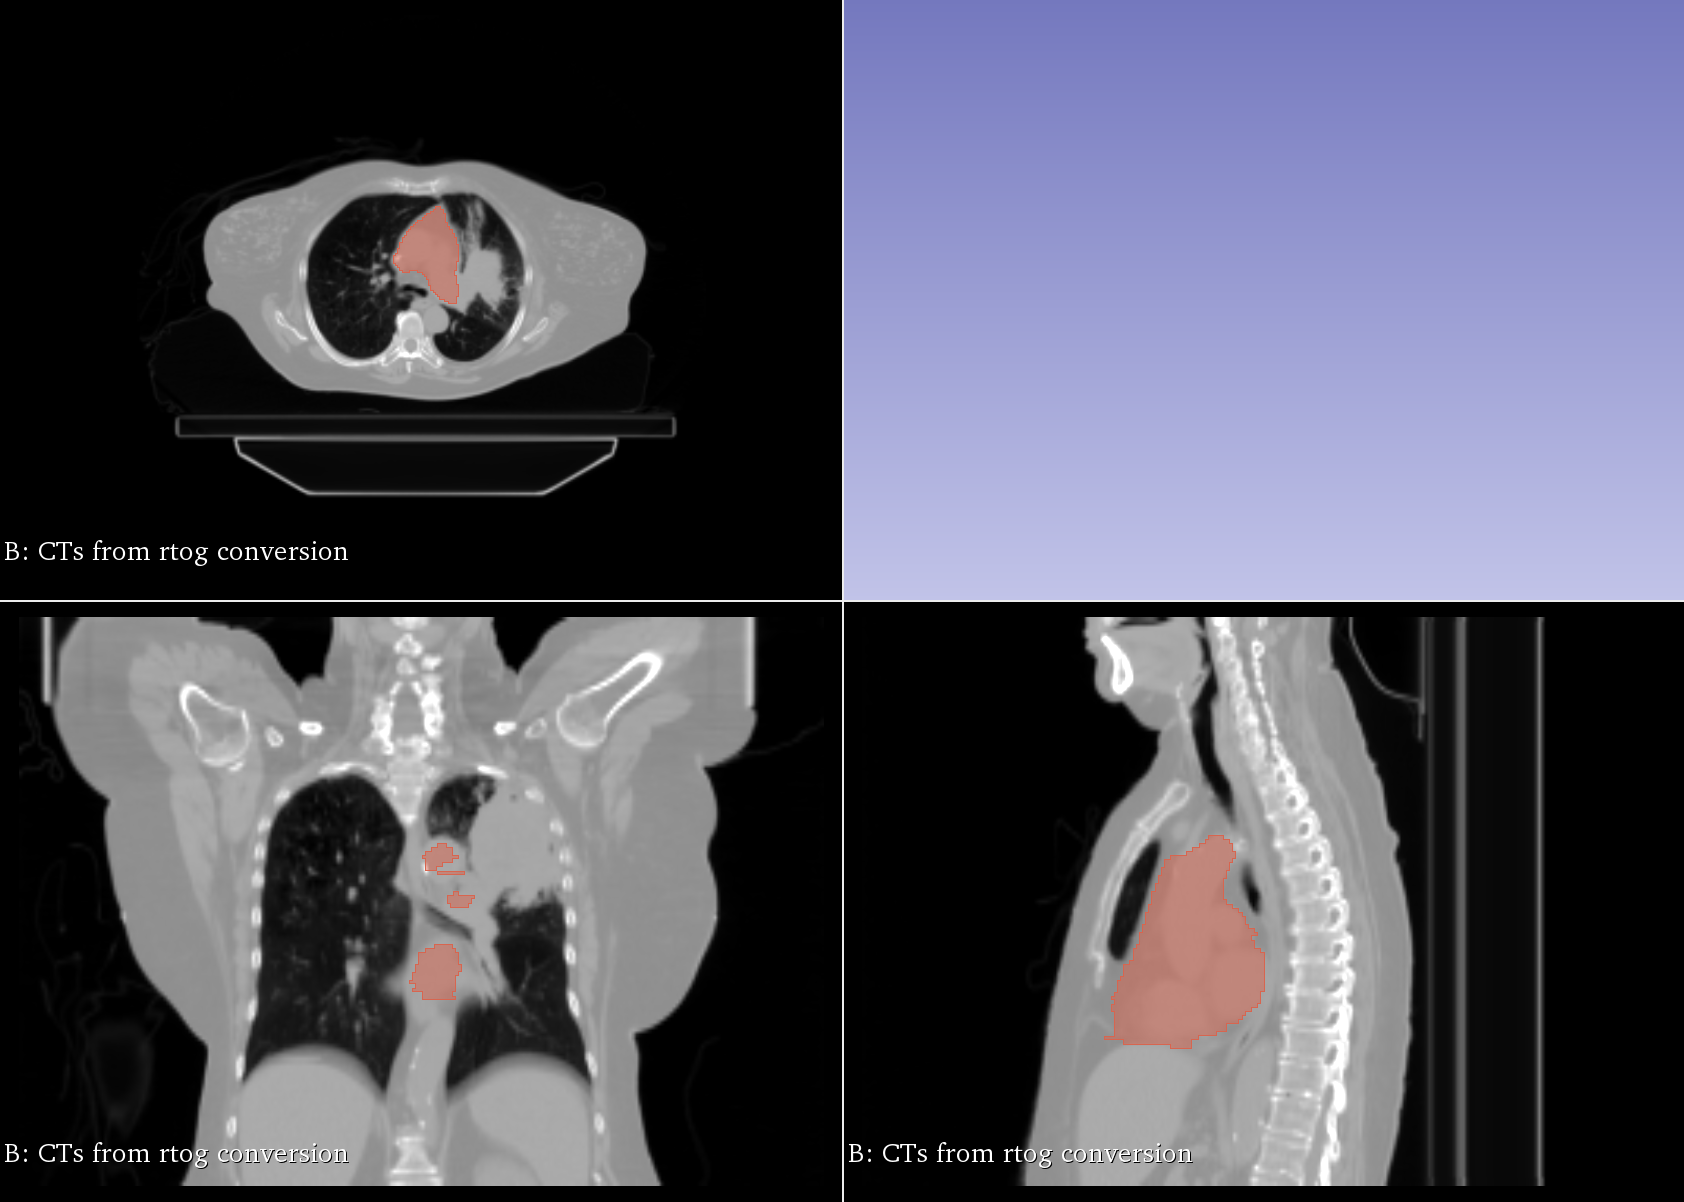

In [51]:
slicernb.ViewDisplay()

In [53]:
print('hi')

hi
